In [1]:
using Revise
using SourceSeparationNF
using MLDatasets
using LinearAlgebra
using ProgressMeter
using Statistics
using PyPlot

BLAS.set_num_threads(1)

In [2]:
# fetch data
train_x, train_y = MNIST.traindata(dir = "../data/MNIST");

In [3]:
# prepare data
train_x_prep = convert(Matrix{Float64}, collect(reshape(train_x, (28*28, 60000))))
train_y_prep = zeros(10, length(train_y))
for k in 1:length(train_y)
    train_y_prep[train_y[k]+1, k] = 1
end

In [4]:
function create_neural_network(dim; optimizer::Type{<:AbstractOptimizer}=Adam, batch_size::Int=128)

    return Model(dim,
        (
            DenseLayer(dim, 8; optimizer=optimizer, batch_size=batch_size),
            ReluLayer(8; batch_size=batch_size),
            DenseLayer(8, 8; optimizer=optimizer, batch_size=batch_size),
            ReluLayer(8; batch_size=batch_size),
            DenseLayer(8, dim; optimizer=optimizer, batch_size=batch_size)
        )
    )

end

create_neural_network (generic function with 1 method)

In [5]:
batch_size = 128

model = Model(
    28*28,
    10,
    (
        MvAdditiveLayer(28*28, create_neural_network(28*14; batch_size=batch_size); batch_size=batch_size),
        PermutationLayer(28*28; batch_size=batch_size),
        MvAdditiveLayer(28*28, create_neural_network(28*14; batch_size=batch_size); batch_size=batch_size),
        DenseLayer(28*28, 10; batch_size=batch_size),
        SoftmaxLayer(10; batch_size=batch_size)
    )
);

In [6]:
isinvertible(model), nr_params(model)

(false, 21338)

In [7]:
setlr!(model, 1e-3)

In [8]:
# allocate for input image
input = Matrix{Float64}(undef, 28*28, batch_size)
output = Matrix{Float64}(undef, 10, batch_size)
loss_function = CCE(batch_size=batch_size);

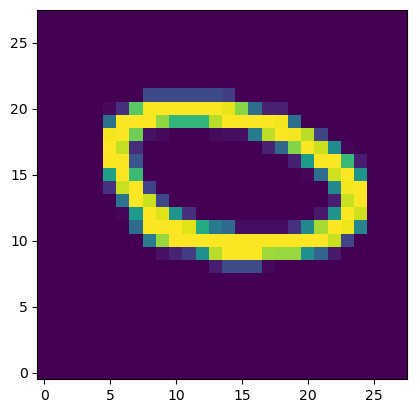

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\s151781\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


10-element Vector{Float64}:
 0.10182220074198862
 0.08247501788237671
 0.06577612059326714
 0.09514109008855051
 0.04474111246528595
 0.046395456046830784
 0.07641446289998864
 0.28525708911013026
 0.09389653494694249
 0.10808091522463899

In [9]:
# show initial prediction
using StatsFuns: softmax
input .= train_x_prep[:,1001:1000+batch_size]
plt.imshow(reshape(input[:,1], (28,28)), origin="lower")
softmax(forward!(model, input)[:,1])

In [10]:
nr_batches = length(1:batch_size:60_000-batch_size)
loss = Vector{Float64}(undef, nr_batches)
@showprogress for epoch in 1:50
    for k in 1:nr_batches
        # load data
        input .= train_x_prep[:,batch_size*(k-1)+1:batch_size*k]
        output .= train_y_prep[:,batch_size*(k-1)+1:batch_size*k]

        # train model
        loss[k] = mean(train!(model, input, output, loss_function))
    end
    println("epoch ", lpad(epoch, 3, "0"), ": ", mean(loss))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:01

epoch 001: 0.05078111537801141
epoch 002: 0.024784201894808205
epoch 003: 0.020796274599861428
epoch 004: 0.018516223230863008
epoch 005: 0.016892991582416698
epoch 006: 0.01569394360164183
epoch 007: 0.01475351528507713
epoch 008: 0.01396100436449837
epoch 009: 0.013345780677081271
epoch 010: 0.012857854285199631
epoch 011: 0.012419494801623007
epoch 012: 0.012002939952524935
epoch 013: 0.011627875657031704
epoch 014: 0.01128652410853499
epoch 015: 0.01100019149684402
epoch 016: 0.010708177258841314
epoch 017: 0.010446335983031923
epoch 018: 0.010190980377353092
epoch 019: 0.00997754218025535
epoch 020: 0.009759569341512687
epoch 021: 0.009552184704006058
epoch 022: 0.009377843756502774
epoch 023: 0.009185820565990235
epoch 024: 0.009005168237495082
epoch 025: 0.008809770191241397
epoch 026: 0.008621943865574553
epoch 027: 0.008450622144492112
epoch 028: 0.008329445233986698
epoch 029: 0.008157149739795123
epoch 030: 0.008031459366884385
epoch 031: 0.00791184905776439
epoch 032: 0.007

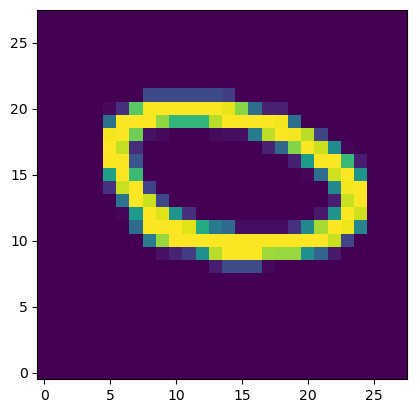

10-element Vector{Float64}:
 0.9998529605664745
 1.123815368009065e-11
 1.7158673539773967e-5
 0.00011991289128805654
 2.7888119464194732e-9
 3.1474973967200575e-7
 1.480797222443751e-6
 4.057873373209432e-6
 3.874038696540717e-6
 2.3760961573339353e-7

In [11]:
# show final prediction
using StatsFuns: softmax
input .= train_x_prep[:,1001:1000+batch_size]
plt.imshow(reshape(input[:,1], (28,28)), origin="lower")
softmax(forward!(model, input)[:,1])

In [12]:
using BenchmarkTools

In [13]:
@benchmark forward!($model)

BenchmarkTools.Trial: 9868 samples with 1 evaluation.
 Range (min … max):  332.300 μs …   3.394 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     396.250 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   499.702 μs ± 233.076 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃▇█▆▅▄▄▄▄▄▃▃▃▃▂▂▃▃▃▂▂▁▁▁   ▁                                  ▂
  ██████████████████████████████▇▆▇▇▆▅▆▇▅▆▆▆▇▆▆▅▅▆▆▆▆▆▄▅▆▅▅▅▄▅▅ █
  332 μs        Histogram: log(frequency) by time       1.55 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [14]:
@benchmark propagate_error!($model)

BenchmarkTools.Trial: 4631 samples with 1 evaluation.
 Range (min … max):  781.200 μs …   3.460 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     926.800 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.070 ms ± 282.256 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▂█▆▁                                                         
  ▁▂████▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▂▂▂▂▂▃▃▂▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  781 μs           Histogram: frequency by time         1.96 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [15]:
@benchmark SourceSeparationNF.update!($model)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  120.400 μs … 465.100 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     127.950 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   130.530 μs ±  10.124 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      █    ▆                                                     
  ▃▂▁▁█▇▃▄▆█▄▃▃▅▆▃▃▂▄▄▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  120 μs           Histogram: frequency by time          169 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [16]:
@benchmark train!($model, $input, $output, $loss_function)

BenchmarkTools.Trial: 2255 samples with 1 evaluation.
 Range (min … max):  1.451 ms …   4.221 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.175 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.200 ms ± 454.356 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▂█▇▆▄▃▂▃▂▃▄▁▃ ▁▁ ▁  ▂   ▁▂▂▂▄▁▂▁▃▄                        
  ▂▂▅█████████████▇████▆▇█▇████████████▅▇▇▇▆▆▄▅▅▅▄▃▃▂▃▂▂▂▂▂▂▂ ▅
  1.45 ms         Histogram: frequency by time        3.33 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.